# Exercício 1:

O arquivo em anexo ("dataset.csv") apresenta um pedaço de um dataset coletado em um estudo sobre doenças cardíacas. As colunas presentes no dataset são as seguintes:

- sbp: systolic blood pressure (pressão arterial sistólica)
- tobacco: consumo cumulativo de tabaco (kg)
- ldl: colesterol de lipoproteína de baixa densidade
- adiposity: adiposidade
- famhist: histórico familiar de doença cardíaca (Present, Absent)
- typea: comportamento tipo-A
- obesity: obesidade
- alcohol: consumo atual de álcool
- age: idade
- chd: apresenta doença coronariana (1 - True, 0 - False)

Use o dataset para desenvolver um modelo linear que estima a probabilidade de uma pessoa do contexto em que o dataset foi coletado apresentar doença coronariana ou não. A partir do modelo desenvolvido, justifique quais aparentam ser os principais fatores de risco relacionados à doença.

### Definindo funções de utilidades

In [ ]:
import matplotlib.pyplot as plt

def plot_report(report):
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  fig.suptitle('Metrics by Class')

  classes = ['0', '1']
  metrics = ['precision', 'recall', 'f1-score']
  macro_metrics = ['precision', 'recall', 'f1-score']

  class_values = [[report[c][m] for c in classes] for m in metrics]
  macro_avg_values = [report['macro avg'][m] for m in macro_metrics]

  for i, metric in enumerate(metrics):
      axes[i].bar(classes, class_values[i], alpha=0.7, label=f'Classe {metric.capitalize()}')
      axes[i].set_xlabel('Classe')
      axes[i].set_ylabel(metric.capitalize())
      axes[i].set_title(f'{metric.capitalize()} por Classe')
      axes[i].set_ylim(0, 1)
      axes[i].grid(axis='y', linestyle='--', alpha=0.7)

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  fig.suptitle('Agregação das Métricas')

  axes[0].bar(macro_metrics, macro_avg_values, alpha=0.7, color='orange')
  axes[0].set_xlabel('Métrica')
  axes[0].set_ylabel('Valor')
  axes[0].set_title('Macro Visualização das Métricas')
  axes[0].set_ylim(0, 1)
  axes[0].grid(axis='y', linestyle='--', alpha=0.7)

  axes[1].bar(['Accuracy'], [report['accuracy']], alpha=0.7, color='green')
  axes[1].set_title('Overall Accuracy')
  axes[1].set_ylim(0, 1)
  axes[1].grid(axis='y', linestyle='--', alpha=0.7)

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [ ]:
import pandas as pd
from tabulate import tabulate

def plot_report_table(report):

  table_data = {
      'Metric': ['Precision', 'Recall', 'F1-Score', 'Support'],
      'Class 0': [report['0']['precision'], report['0']['recall'], report['0']['f1-score'], report['0']['support']],
      'Class 1': [report['1']['precision'], report['1']['recall'], report['1']['f1-score'], report['1']['support']],
      'Macro Avg': [report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'], report['macro avg']['support']],
      'Weighted Avg': [report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'], report['weighted avg']['support']],
      'Accuracy': ['', '', report['accuracy'], '']
  }

  df = pd.DataFrame(table_data)

  print(tabulate(df, headers='keys', tablefmt='pretty'))

### Introdução

Importando o Dataset para um pandas DataFrame

In [ ]:
import pandas as pd

df = pd.read_csv("/content/dataset.csv")

Inicia-se o processo verificando o balanceamento desse dataset para cada uma das duas classes de alvo. Aqui, percebe-se um desbalanceamenro entre as classes, já que as amostras que apresentam um apontamento falso do quadro clinico são quase o dobro das que apresentam de fato.

<Axes: xlabel='chd'>

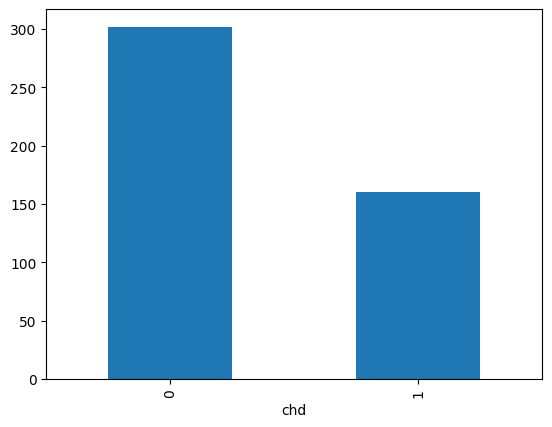

In [ ]:
df['chd'].value_counts().plot(kind='bar')

A variável famhist (histórico familiar de doença cardíaca) é categórica (textual), o que significa que não pode ser processada por um modelo linear a não ser que seja realizado algum tipo de pre processamento. Por isso, por ter apenas dois valores, foi decidido mapear os casos de presentes como 1 e os ausentes como 0.

In [ ]:
df['famhist'] = df['famhist'].map({'Present': 1, 'Absent': 0})

É necessário remover a coluna chd (apresenta doença coronariana) do conjunto de dados e separá-la em um conjunto de alvos, pois ela representa os rótulos/respostas que o modelo deve ter como verdadeiros.

In [ ]:
X = df.drop(columns=['id', 'chd'])
y = df['chd']

Aqui realiza-se o processo de divisão do dataset entre treino e testes, pois precisamos de um conjunto que o modelo não tenha visto durante o treinamento para validar sua capacidade de generalização.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Analisando relação entre as features e o target

<ipython-input-86-64dcc0917da9>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


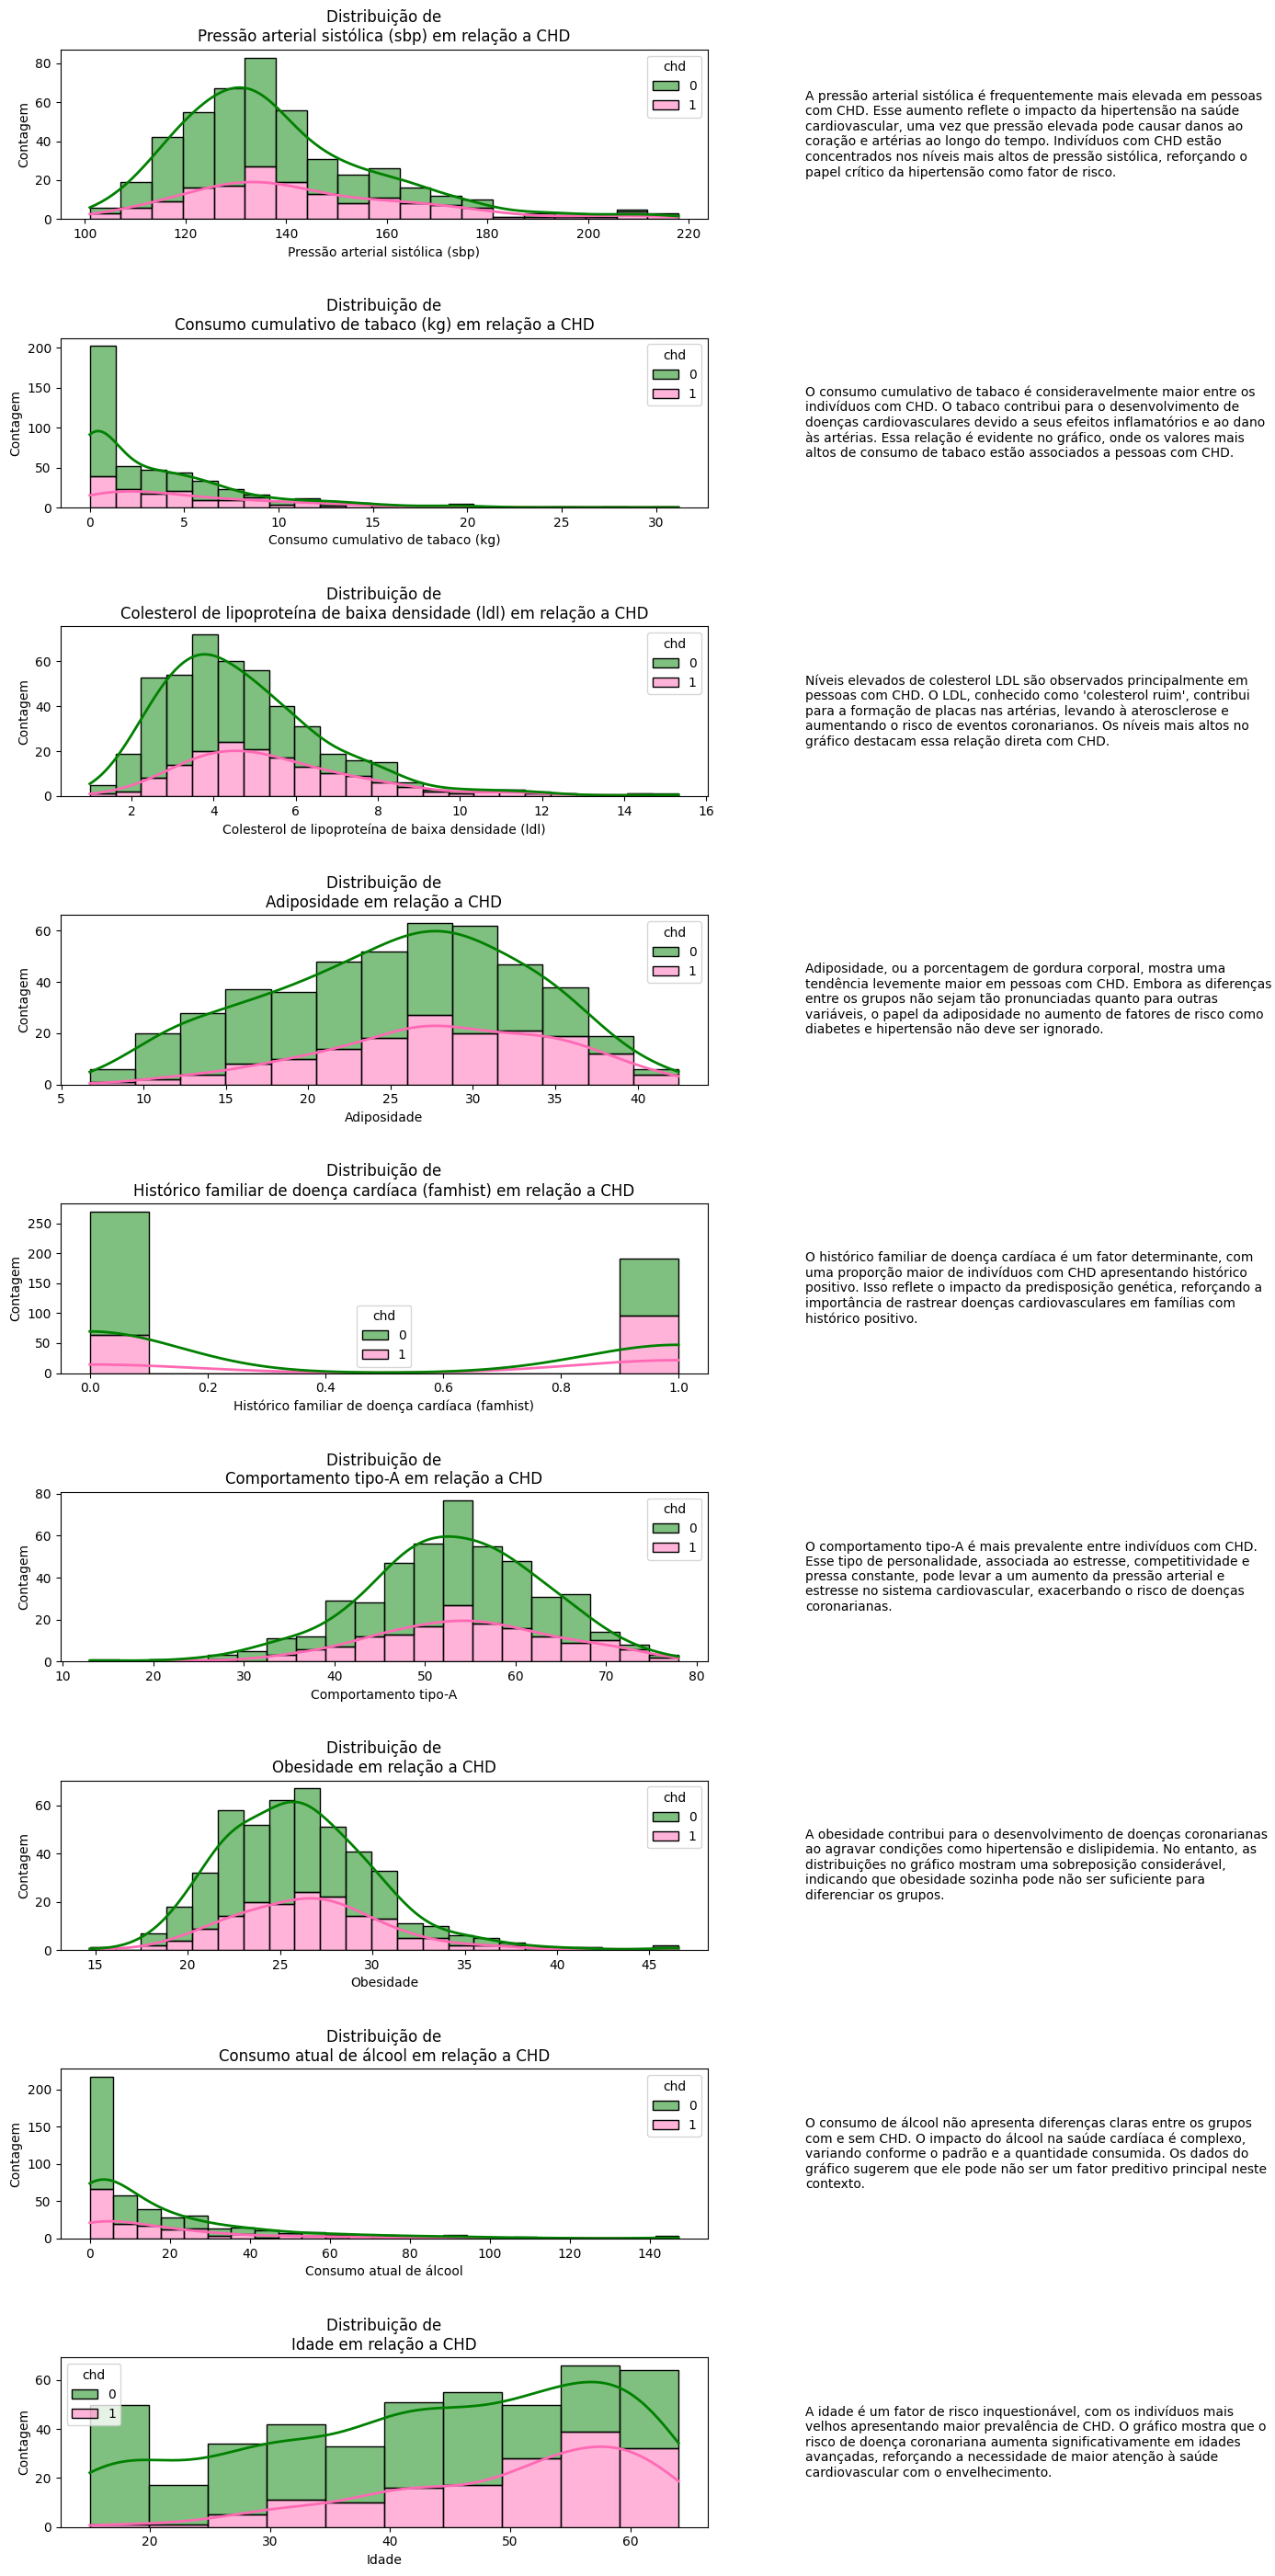

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

custom_palette = {0: "green", 1: "#FF69B4"}

titulos = {
    "sbp": "Pressão arterial sistólica (sbp)",
    "tobacco": "Consumo cumulativo de tabaco (kg)",
    "ldl": "Colesterol de lipoproteína de baixa densidade (ldl)",
    "adiposity": "Adiposidade",
    "famhist": "Histórico familiar de doença cardíaca (famhist)",
    "typea": "Comportamento tipo-A",
    "obesity": "Obesidade",
    "alcohol": "Consumo atual de álcool",
    "age": "Idade"
}

comentarios_detalhados = {
    "sbp": (
        "A pressão arterial sistólica é frequentemente mais elevada em pessoas com CHD. "
        "Esse aumento reflete o impacto da hipertensão na saúde cardiovascular, "
        "uma vez que pressão elevada pode causar danos ao coração e artérias ao longo do tempo. "
        "Indivíduos com CHD estão concentrados nos níveis mais altos de pressão sistólica, "
        "reforçando o papel crítico da hipertensão como fator de risco."
    ),
    "tobacco": (
        "O consumo cumulativo de tabaco é consideravelmente maior entre os indivíduos com CHD. "
        "O tabaco contribui para o desenvolvimento de doenças cardiovasculares devido a seus efeitos "
        "inflamatórios e ao dano às artérias. Essa relação é evidente no gráfico, onde os valores "
        "mais altos de consumo de tabaco estão associados a pessoas com CHD."
    ),
    "ldl": (
        "Níveis elevados de colesterol LDL são observados principalmente em pessoas com CHD. "
        "O LDL, conhecido como 'colesterol ruim', contribui para a formação de placas nas artérias, "
        "levando à aterosclerose e aumentando o risco de eventos coronarianos. "
        "Os níveis mais altos no gráfico destacam essa relação direta com CHD."
    ),
    "adiposity": (
        "Adiposidade, ou a porcentagem de gordura corporal, mostra uma tendência levemente maior em pessoas com CHD. "
        "Embora as diferenças entre os grupos não sejam tão pronunciadas quanto para outras variáveis, "
        "o papel da adiposidade no aumento de fatores de risco como diabetes e hipertensão não deve ser ignorado."
    ),
    "famhist": (
        "O histórico familiar de doença cardíaca é um fator determinante, com uma proporção maior de indivíduos com CHD "
        "apresentando histórico positivo. Isso reflete o impacto da predisposição genética, "
        "reforçando a importância de rastrear doenças cardiovasculares em famílias com histórico positivo."
    ),
    "typea": (
        "O comportamento tipo-A é mais prevalente entre indivíduos com CHD. Esse tipo de personalidade, "
        "associada ao estresse, competitividade e pressa constante, pode levar a um aumento da pressão arterial e "
        "estresse no sistema cardiovascular, exacerbando o risco de doenças coronarianas."
    ),
    "obesity": (
        "A obesidade contribui para o desenvolvimento de doenças coronarianas ao agravar condições como hipertensão e "
        "dislipidemia. No entanto, as distribuições no gráfico mostram uma sobreposição considerável, indicando "
        "que obesidade sozinha pode não ser suficiente para diferenciar os grupos."
    ),
    "alcohol": (
        "O consumo de álcool não apresenta diferenças claras entre os grupos com e sem CHD. "
        "O impacto do álcool na saúde cardíaca é complexo, variando conforme o padrão e a quantidade consumida. "
        "Os dados do gráfico sugerem que ele pode não ser um fator preditivo principal neste contexto."
    ),
    "age": (
        "A idade é um fator de risco inquestionável, com os indivíduos mais velhos apresentando maior prevalência de CHD. "
        "O gráfico mostra que o risco de doença coronariana aumenta significativamente em idades avançadas, "
        "reforçando a necessidade de maior atenção à saúde cardiovascular com o envelhecimento."
    )
}

fig = plt.figure(figsize=(15, 35))
gs = GridSpec(len(df.columns[1:-1]), 2, width_ratios=[2, 1], hspace=0.7)

for i, col in enumerate(df.columns[1:-1]):
    ax_graph = fig.add_subplot(gs[i, 0])
    sns.histplot(
        data=df, x=col, hue='chd', multiple='stack', kde=True, palette=custom_palette,
        line_kws={"linewidth": 2}, ax=ax_graph
    )
    ax_graph.set_title(f"Distribuição de\n{titulos[col]} em relação a CHD", fontsize=12)
    ax_graph.set_xlabel(titulos[col], fontsize=10)
    ax_graph.set_ylabel("Contagem", fontsize=10)

    ax_comment = fig.add_subplot(gs[i, 1])
    ax_comment.axis("off")
    ax_comment.text(0, 0.5, comentarios_detalhados[col], fontsize=10, wrap=True, va="center")

plt.tight_layout()
plt.show()


### Modelo De Regressão Logística

Por se tratar de um problema de classificação binária (0 para doença ausente ou 1 para doença presente), treina-se um modelo de regressão logística para realizar predições.

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

A função classification_report permite recuperar várias métricas de avaliação do modelo, dentre elas:

- **Precision**: É a proporção de predições positivas corretas em relação ao total de predições positivas feitas pelo modelo. Ela mede a exatidão das predições positivas. Um valor alto indica que o modelo comete poucos erros ao classificar exemplos negativos como positivos.

  **Precision = TP / (TP + FP)**

</br>
</br>

- **Recall**:  É a proporção de predições positivas corretas em relação ao total de exemplos positivos reais. Ela mede a capacidade do modelo de encontrar todos os exemplos positivos reais. Um valor alto indica que poucos exemplos positivos reais foram perdidos.

  **Recall** = TP / (TP + FN)

</br>
</br>

- **F1-Score**: É a média harmônica entre a precisão e o recall, balanceando as duas métricas. Fornece uma medida única que considera tanto os falsos positivos quanto os falsos negativos. É útil quando há um desequilíbrio entre as classes.

  **F1-Score** = 2 * [Precision * Recall / (Precision + Recall)]

</br>
</br>

- **Support**: É o número total de exemplos reais de cada classe no conjunto de dados. Ela mostra a quantidade de dados disponíveis para avaliar cada classe. Classes com menor suporte podem apresentar métricas menos confiáveis.

</br>
</br>

- **Macro Average**: Definição: É a média das métricas (precisão, recall e F1-score) calculada para cada classe de forma independente, sem considerar o suporte. Dá igual peso a todas as classes, independentemente do número de exemplos em cada uma. Pode ser útil para avaliar o desempenho em classes desbalanceadas.

  **Macro Average** = (Métrica Classe 0 + Métrica Classe 1) / 2

</br>
</br>

- **Weighted Average**: É a média ponderada das métricas (precisão, recall e F1-score), levando em conta o suporte de cada classe. Considera o tamanho de cada classe, sendo mais representativa em conjuntos desbalanceados.

  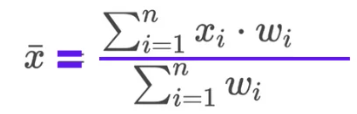

  wi Representa o suporte da classe i
  xi representa a métrica da classe i

</br>
</br>

- **Acurácia**: É a proporção de predições corretas em relação ao total de exemplos avaliados. Mede o desempenho geral do modelo. Pode ser enganosa em conjuntos de dados desbalanceados (por exemplo, se a maioria dos exemplos pertence a uma única classe).

 **Acurácia** = (TP + TN) / N


Obs: Considere para as fórmulas acima:

TP = True Positive </br>
FP = False Positive </br>
TN = True Negative </br>
FN = False Negative </br>
N = Número de amostras </br>



Devido à natureza do problema que estamos tentando predizer, é perceptível que a Recall é a melhor métrica para avaliarmos a eficácia do nosso modelo. Isso porque nosso dataset é desbalanceado, o que provoca uma distorção na compreensão da acurácia, já que o modelo possuirá um viez de classificação para a classe majoritária (0 - pessoas não doentes), e como esse modelo pode acabar acertando muitos casos negativos que estão presentes no dataset, uma alta acurácia pode não significar um bom resultado para a classe minoritária (1 - doença presente). Por isso, a recall se torna uma métrica ideal, pois ela vai avaliar as predições das classes de forma separada e vai favorecer modelos que são capazes de acertar somente quando necessário, evitando transtornos de doenças erroneamente identificadas em pacientes, como é o caso desse problema.  

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

Visualização Gráfica das métricas de avaliação

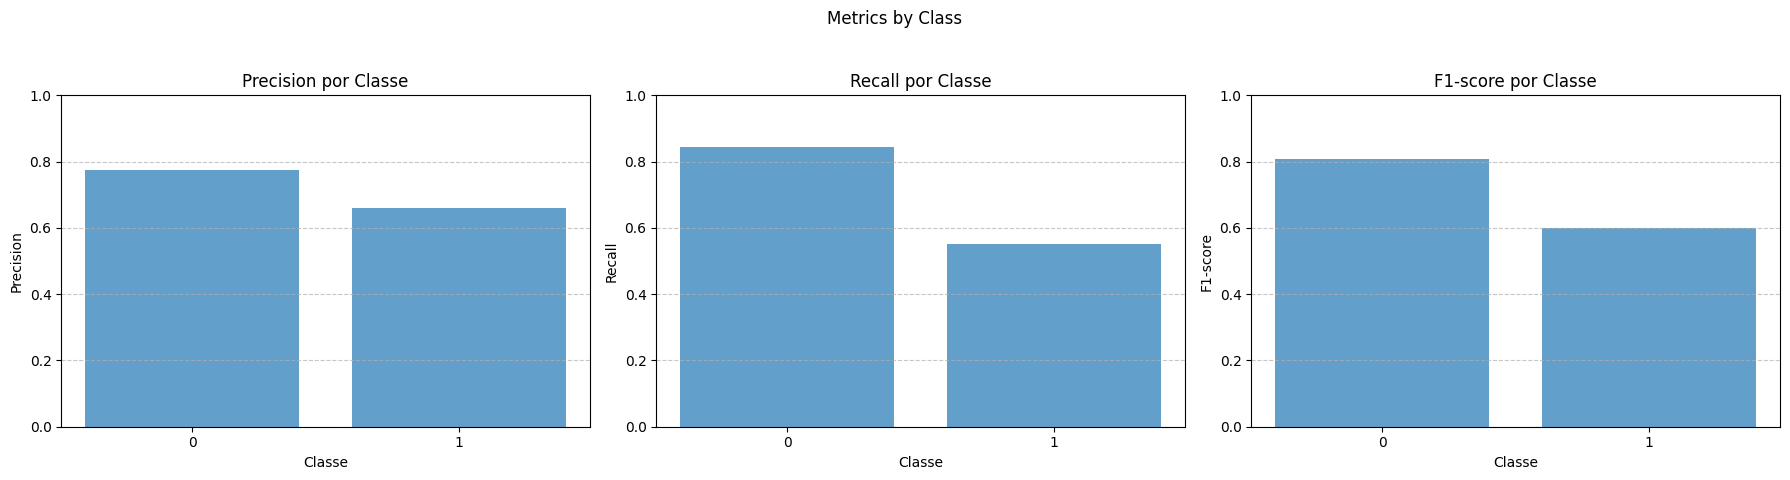

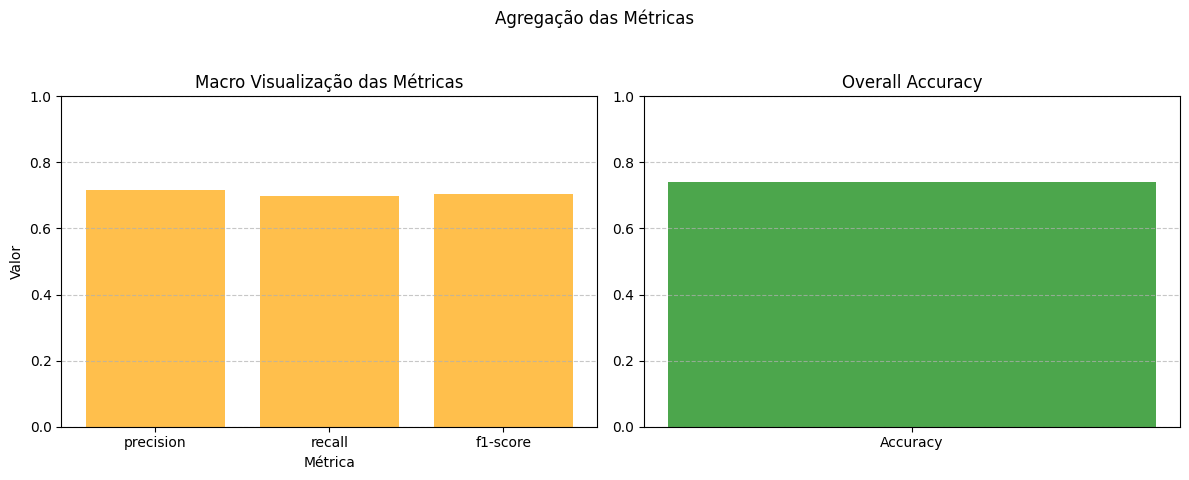

In [ ]:
plot_report(report)

Visualização em Tabela das métricas de avaliação. Como pode ser visto abaixo, a acurácia possui um valor razoável, mas a Recall da classe 1 está com um valor muito próximo dos 50%, o que sugere que nosso modelo está com o viés de classificar as amostras como casos negativos para a doença, não performando bem na identificação de casos reais.

In [ ]:
plot_report_table(report)

+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |  Metric   |      Class 0       |      Class 1       |     Macro Avg      |    Weighted Avg    |      Accuracy      |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0 | Precision | 0.7755102040816326 | 0.6585365853658537 | 0.7170233947237432 | 0.7342748996422573 |                    |
| 1 |  Recall   | 0.8444444444444444 | 0.5510204081632653 | 0.6977324263038549 | 0.7410071942446043 |                    |
| 2 | F1-Score  | 0.8085106382978723 |        0.6         | 0.7042553191489361 | 0.735006888106536  | 0.7410071942446043 |
| 3 |  Support  |        90.0        |        49.0        |       139.0        |       139.0        |                    |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


### Balanceando Dataset

Na tentativa de balancear o dataset ao igualar a quantidade de dados que possuem o rótulo 0 com o rótulo 1, podemos utilizar a biblioteca imbalanced-learn para realizar esse recorte.

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

sampling_model = LogisticRegression(max_iter=1000)
sampling_model.fit(X_balanced, y_balanced)

LogisticRegression(max_iter=1000)

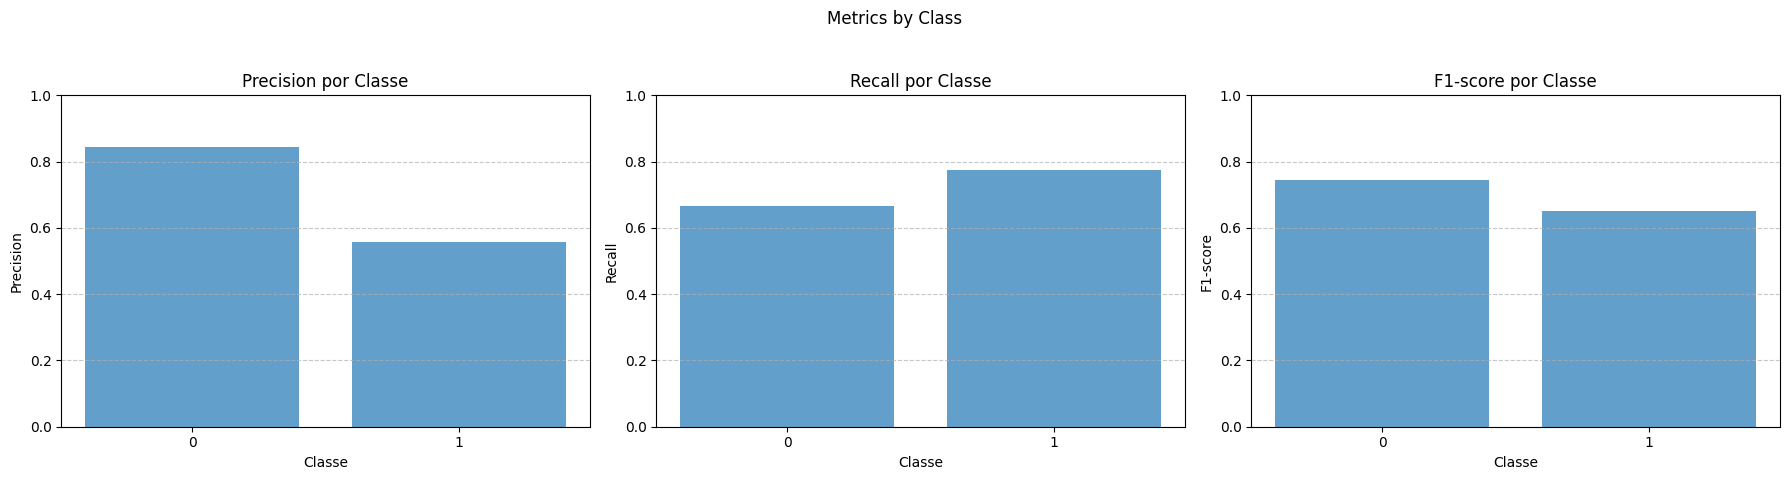

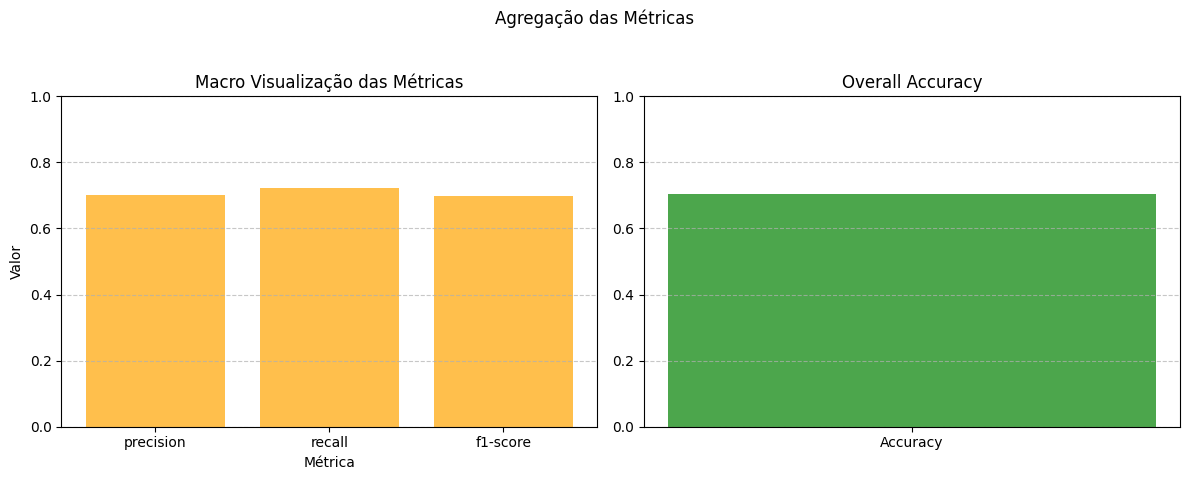

+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |  Metric   |      Class 0       |      Class 1       |     Macro Avg      |    Weighted Avg    |      Accuracy      |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0 | Precision | 0.8450704225352113 | 0.5588235294117647 | 0.701946975973488  | 0.7441632443837805 |                    |
| 1 |  Recall   | 0.6666666666666666 | 0.7755102040816326 | 0.7210884353741496 | 0.7050359712230215 |                    |
| 2 | F1-Score  | 0.7453416149068323 | 0.6495726495726496 | 0.6974571322397409 | 0.7115813321631276 | 0.7050359712230215 |
| 3 |  Support  |        90.0        |        49.0        |       139.0        |       139.0        |                    |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
sampling_y_pred = sampling_model.predict(X_test)

sampling_report = classification_report(y_test, sampling_y_pred, output_dict=True)
plot_report(sampling_report)
plot_report_table(sampling_report)

Nesse caso, como houve um corte expressivo do número de casos negativos (0) (o que representa quase um terço do dataset original), percebe-se que a recall dessa classe caiu consideravelmente, enquanto o da classe positiva (1) cresceu bastante. Isso aponta um viés do modelo em classificar as amostras como da classe 1. A queda na acurácia também pode ser eplicada por esse fato.

### Modelo Balanceado

Para tentar resolver o problema de desbalanceamento das classes, é possível atribuir pesos às classes utilizando o atributo class_weight, que, se configurado como 'balanced', automaticamente é capaz de ajustar os pesos que cada classe possui com base na frequência inversa em que cada uma delas aparece

n_samples / (n_classes * np.bincount(y))

Isso penaliza classes que aparecem muitas vezes e tenta corrigir o viés do modelo em classificar as amostras apenas como casos negativos.

In [ ]:
from sklearn.linear_model import LogisticRegression
balanced_model = LogisticRegression(max_iter=1000, class_weight='balanced')
balanced_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
balanced_y_pred = balanced_model.predict(X_test)
balanced_report = classification_report(y_test, balanced_y_pred, output_dict=True)

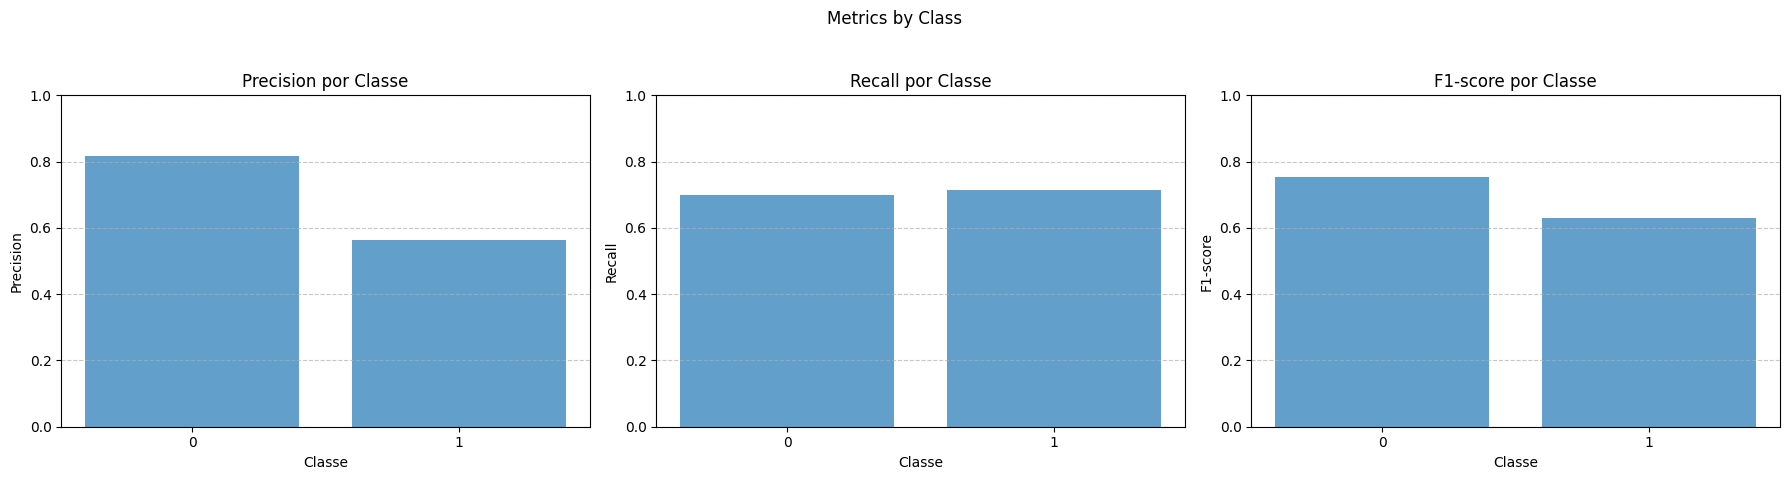

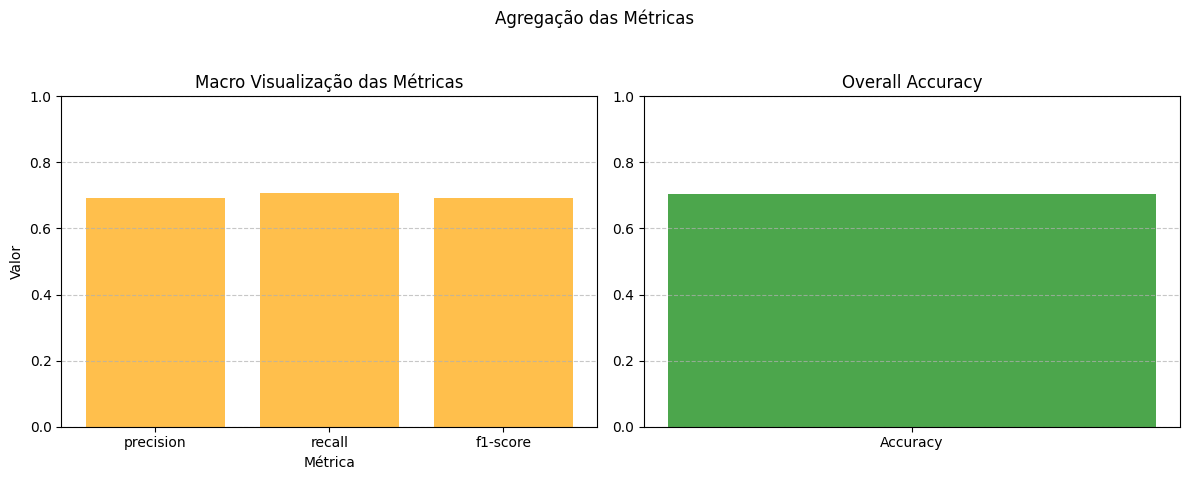

+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |  Metric   |      Class 0       |      Class 1       |     Macro Avg      |    Weighted Avg    |      Accuracy      |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0 | Precision | 0.8181818181818182 | 0.5645161290322581 | 0.6913489736070382 | 0.7287601004240597 |                    |
| 1 |  Recall   |        0.7         | 0.7142857142857143 | 0.7071428571428571 | 0.7050359712230215 |                    |
| 2 | F1-Score  | 0.7544910179640718 | 0.6306306306306306 | 0.6925608242973512 | 0.7108280037242256 | 0.7050359712230215 |
| 3 |  Support  |        90.0        |        49.0        |       139.0        |       139.0        |                    |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
plot_report(balanced_report)
plot_report_table(balanced_report)

Percebe-se que houve uma diminuição da acurácia, mas um aumento na recall da classe positiva (1), o que torna nosso modelo mais eficiente para prever casos positivos. A diminuição da acurácia aponta justamente a perda do viés em classificar os dados sempre como negativos, pois como esses estão mais presentes no dataset, se o modelo tende a classificar os dados de forma a não o priorizar, ele passa a errar mais nesses casos. Isso explica a diminuição da recall da classe 0.

### Escalonando Dados

Devido às diferenças de grandezas presentes entre as features numéricas, poderíamos considerar necessário realizar um processo de normalização entre elas para evitar que o modelo leve em consideração os valores maiores e desconsidere valores pequenos, pois esse comparativo não pode ser feito em escalas diferentes.

Para isso, utiliza-se o StandardScaler, que realiza automaticamente a normalização dos dados numéricos, ou seja

zi = (xi - u) / s

Todos os dados serão substituídos por zi, onde

xi = valor original
u = média dos dados
s = desvio padrão dos dados

A normalização poderia auxiliar no processo de otimização do modelo durante o treinamento, pois as influências das diferentes grandezas não mitigadas, o que pode melhorar a estabilidade durante o treino e a precisão do modelo.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
scaled_model = LogisticRegression(class_weight='balanced')
scaled_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
y_pred_scaled = scaled_model.predict(X_test_scaled)
scaled_report = classification_report(y_test, y_pred_scaled, output_dict=True)

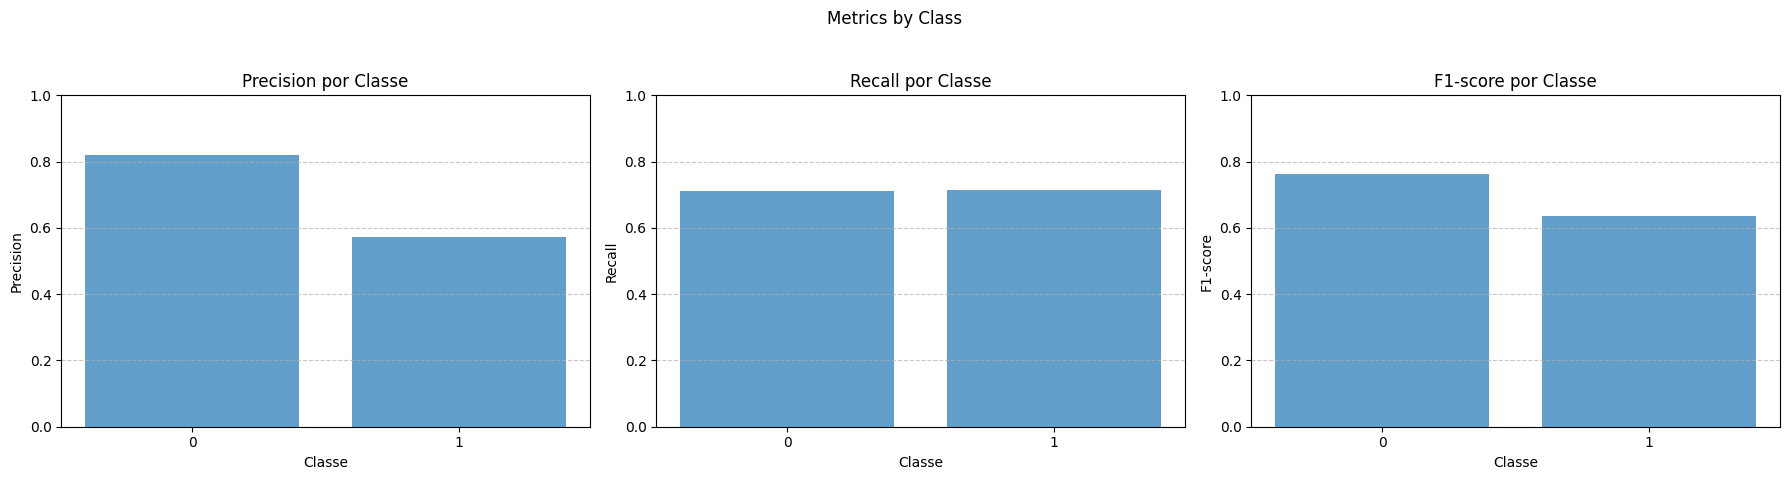

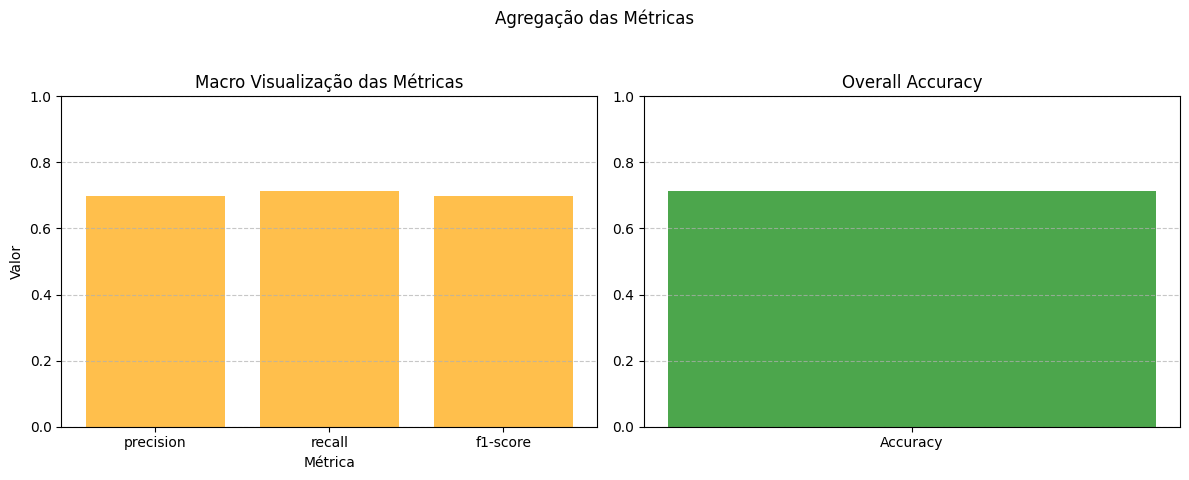

In [ ]:
plot_report(scaled_report)

In [ ]:
plot_report_table(scaled_report)

+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |  Metric   |      Class 0       |      Class 1       |     Macro Avg      |    Weighted Avg    |      Accuracy      |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0 | Precision | 0.8205128205128205 | 0.5737704918032787 | 0.6971416561580496 | 0.7335317118310396 |                    |
| 1 |  Recall   | 0.7111111111111111 | 0.7142857142857143 | 0.7126984126984127 | 0.7122302158273381 |                    |
| 2 | F1-Score  | 0.7619047619047619 | 0.6363636363636364 | 0.699134199134199  | 0.7176492572176024 | 0.7122302158273381 |
| 3 |  Support  |        90.0        |        49.0        |       139.0        |       139.0        |                    |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


É visível que a normalização não alterou a recall do modelo, o que levanta a hipótese de que talvez, para esse caso, a diferença entre as grandezas junto da aplicação da Regressão Logística não seja tão eficaz para a resolução do problema. Isso pode decorrer do fato de quem, dentre as features mais significativas para se predizer a presença de doença em um paciente, as diferenças de escala/distâncias numéricas não sejam significativas.


### Avaliação de features significativas

Por isso, pode-se tentar avaliar quais variáveis mais impactam no resultado final que prevê a classe de uma amostra. Aqui, percebe-se que o famhist (histórico familiar), o ldl (colesterol de lipoproteína de baixa densidade) e a tobacco são as features mais importantes para definir se um paciente possui ou não a doença, pois sues coeficientes não os mais altos entre as features para modelo de Regressão Logística.

In [ ]:
import numpy as np

coefficients = balanced_model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coeficiente": coefficients
}).sort_values(by="Coeficiente", key=np.abs, ascending=False)

coef_df

,Feature,Coeficiente
4,famhist,0.676216
2,ldl,0.198403
1,tobacco,0.061994
6,obesity,-0.061676
8,age,0.043210
5,typea,0.039776
3,adiposity,0.025219
0,sbp,0.008815
7,alcohol,0.001446


### Aplicando validação cruzada

Na tentativa de verificar o impacto dessas featires no modelo, pode-se utilizar a validação cruzada para validar o treinamento em diferentes partes do dataset e verificar a consistência do impacto dessas variáveis mais impactantes.

Aqui, o resultado da acurácia próximo dos anteriores comprova que o impacto dessas variáveis é o mesmo para diferentes grupos do dataset, pois o recall continua próximo do visto nos resultados anteriores (~0,72)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='recall')
mean_recall = cv_scores.mean()
std_recall = cv_scores.std()
mean_recall, std_recall

(0.71875, 0.03423265984407288)

Podemos tentar remover os outliers para verificar se isso causa alguma melhora na recall.

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

features_to_check = ['famhist', 'ldl', 'tobacco']

z_scores = np.abs(zscore(df[features_to_check]))
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

df_cleaned = df[~outliers]

X_cleaned_high = df_cleaned.drop(columns=['id', 'chd'])
y_cleaned_high = df_cleaned['chd']

cleaned_model = LogisticRegression(max_iter=1000, class_weight='balanced')

cv_scores_cleaned = cross_val_score(cleaned_model, X_cleaned_high, y_cleaned_high, cv=5, scoring='recall')
mean_recall_cleaned = cv_scores_cleaned.mean()
std_recall_cleaned = cv_scores_cleaned.std()

mean_recall_cleaned, std_recall_cleaned

(0.720919540229885, 0.0271459115754032)

Nota-se um pequeno aumento na recall e uma diminuição no seu desvio padrão, o que demonstra maior estabilidade da métrica entre os diferentes conjuntos do dataset.  

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import zscore
features_to_check = ['adiposity', 'sbp', 'alcohol']

z_scores = np.abs(zscore(df[features_to_check]))
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

df_cleaned = df[~outliers]

X_cleaned_low = df_cleaned.drop(columns=['id', 'chd'])
y_cleaned_low = df_cleaned['chd']

cleaned_model = LogisticRegression(max_iter=1000, class_weight='balanced')

cv_scores_cleaned = cross_val_score(cleaned_model, X_cleaned_low, y_cleaned_low, cv=5, scoring='recall')
mean_recall_cleaned = cv_scores_cleaned.mean()
std_recall_cleaned = cv_scores_cleaned.std()

mean_recall_cleaned, std_recall_cleaned

(0.7386206896551725, 0.036785919287700246)

Nesse caso, removeu-se os outliers de features menos significativas, o que também aumentou o recall, mas provocou maior variação dle antre os grupos do dataset

### Aplicando regularização

Tentando penalizar valores absolutos dos coficientes

In [ ]:
l1_model = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', class_weight='balanced')

l1_model.fit(X_cleaned_high, y_cleaned_high)

l1_report = classification_report(y_cleaned_high, l1_model.predict(X_cleaned_high), output_dict=True)

plot_report_table(l1_report)

+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |  Metric   |      Class 0       |      Class 1       |     Macro Avg      |    Weighted Avg    |      Accuracy      |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0 | Precision | 0.8423236514522822 | 0.5369458128078818 | 0.689634732130082  | 0.7412188264956902 |                    |
| 1 |  Recall   | 0.6835016835016835 | 0.7414965986394558 | 0.7124991410705697 | 0.7027027027027027 |                    |
| 2 | F1-Score  | 0.7546468401486989 | 0.6228571428571429 | 0.6887519915029209 | 0.7110137646940621 | 0.7027027027027027 |
| 3 |  Support  |       297.0        |       147.0        |       444.0        |       444.0        |                    |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
from sklearn.linear_model import LogisticRegressionCV

regularized_model = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', scoring='recall', random_state=42, class_weight='balanced')
regularized_model.fit(X_cleaned_high, y_cleaned_high)

cv_scores_regularized = cross_val_score(regularized_model, X_cleaned_high, y_cleaned_high, cv=5, scoring='recall')

mean_recall_regularized = cv_scores_regularized.mean()
std_recall_regularized = cv_scores_regularized.std()

mean_recall_regularized, std_recall_regularized

(0.7068965517241379, 0.048960660273927877)

### Testando apenas as features relevantes

In [ ]:
relevant_features = ['famhist', 'ldl', 'tobacco']
X_relevant = df_cleaned[relevant_features]
y_relevant = df_cleaned['chd']

l1_model_relevant = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', class_weight='balanced')

l1_model_relevant.fit(X_relevant, y_relevant)

l1_report_relevant = classification_report(y_relevant, l1_model_relevant.predict(X_relevant), output_dict=True)

plot_report_table(l1_report_relevant)

+---+-----------+--------------------+-------------------+--------------------+--------------------+--------------------+
|   |  Metric   |      Class 0       |      Class 1      |     Macro Avg      |    Weighted Avg    |      Accuracy      |
+---+-----------+--------------------+-------------------+--------------------+--------------------+--------------------+
| 0 | Precision |       0.8125       | 0.526595744680851 | 0.6695478723404256 | 0.7178425100632547 |                    |
| 1 |  Recall   | 0.7003367003367004 | 0.673469387755102 | 0.6869030440459012 | 0.6914414414414415 |                    |
| 2 | F1-Score  | 0.7522603978300181 | 0.591044776119403 | 0.6716525869747105 | 0.698884955506909  | 0.6914414414414415 |
| 3 |  Support  |       297.0        |       147.0       |       444.0        |       444.0        |                    |
+---+-----------+--------------------+-------------------+--------------------+--------------------+--------------------+


### Curva ROC

Curva ROC (Receiver Operating Characteristic), que é uma ferramenta de avaliação para modelos de classificação.

Curva ROC e AUC Curva ROC ilustra a relação entre a Taxa de Verdadeiros Positivos (Sensibilidade) e a Taxa de Falsos Positivos para diferentes valores de threshold (limiar de decisão). A linha laranja representa o desempenho do modelo em diferentes thresholds. A linha azul diagonal representa uma classificação aleatória, ou seja, um modelo sem poder preditivo (AUC = 0.5). AUC (Área Sob a Curva): Neste caso, o valor do AUC é 0.79. Isso significa que o modelo tem um desempenho razoável, conseguindo distinguir a classe positiva (CHD = 1) da classe negativa (CHD = 0) com 79% de precisão em média.

</br>
</br>

Threshold Ideal O Threshold Ideal foi calculado para alcançar uma Sensibilidade (TPR) de pelo menos 90%, reduzindo o número de Falsos Negativos (pessoas com CHD classificadas incorretamente como saudáveis). Threshold Ideal: 0.239 Com esse threshold, qualquer probabilidade predita maior ou igual a 0.239 será classificada como positiva (CHD = 1), enquanto valores abaixo disso serão classificados como negativos (CHD = 0). Este threshold é menor que o padrão de 0.5, porque o objetivo é aumentar a sensibilidade, mesmo que isso resulte em mais falsos positivos.

</br>
</br>

Desempenho com o Threshold Ideal Sensibilidade (TPR): 0.901 (90.1%) O modelo detecta corretamente 90.1% dos casos positivos (CHD = 1). Isso é crucial em cenários onde minimizar falsos negativos é prioritário. Taxa de Falsos Positivos (FPR): 0.573 (57.3%) Cerca de 57.3% dos casos negativos (CHD = 0) foram classificados incorretamente como positivos. Isso é aceitável, dado que o custo de falsos negativos é maior.

</br>
</br>

O threshold de 0.239 é adequado para um exame preventivo, pois reduz falsos negativos ao custo de um aumento nos falsos positivos. Isso é aceitável porque um falso negativo tem consequências duas vezes piores. O AUC (0.79) indica que o modelo tem bom desempenho geral, embora haja espaço para melhorias. Trade-off entre TPR e FPR: A sensibilidade foi priorizada para identificar corretamente o maior número de casos positivos, mesmo que isso aumente falsos positivos.

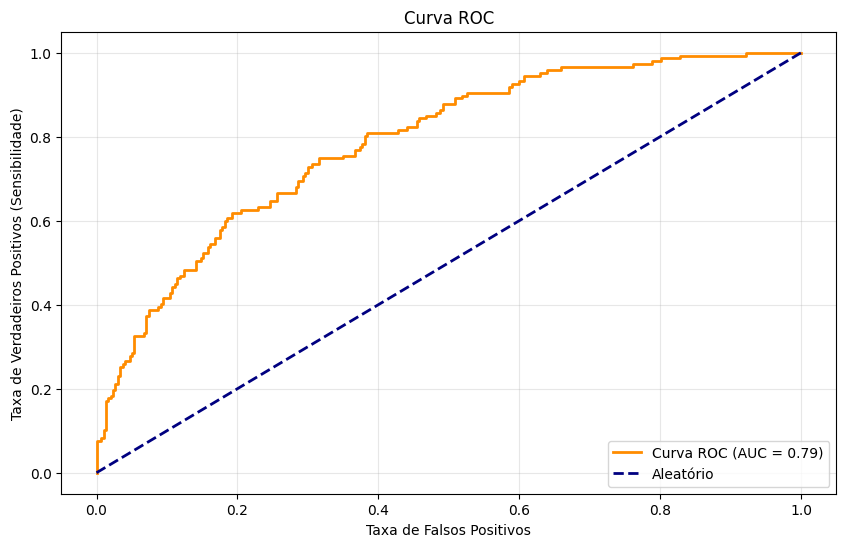

{'Threshold Ideal': 0.31753775250136046,
 'Sensibilidade (TPR)': 0.9047619047619048,
 'Taxa de Falsos Positivos (FPR)': 0.5252525252525253}

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_proba = balanced_model.predict_proba(X_cleaned_high)[:, 1]

fpr, tpr, thresholds = roc_curve(y_cleaned_high, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Aleatório")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos (Sensibilidade)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

desired_sensitivity = 0.90
optimal_idx = np.argmax(tpr >= desired_sensitivity)
optimal_threshold = thresholds[optimal_idx]

optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]

optimal_info = {
    "Threshold Ideal": optimal_threshold,
    "Sensibilidade (TPR)": optimal_tpr,
    "Taxa de Falsos Positivos (FPR)": optimal_fpr
}

optimal_info

# Exercício 2:

Imagine que seu grupo decide usar esse modelo como um exame preventivo para a doença. Considerando que um resultado falso negativo desse exame gera consequências 2 vezes piores para o paciente do que um resultado falso positivo, qual deve ser o procedimento para gerar o resultado do exame a partir do output do modelo?

Esse contexto, em que o falso negativo gera consequências 2 vezes piores do que o falso positivo, é comum no diagnóstico de muitas doenças, onde é empregado um exame inicial de triagem, com objetivo de garantir que a maioria dos casos positivos sejam identificados, seguido por um exame mais específico para confirmar o diagnóstico. Por exemplo, pensando em câncer de mama, é utilizado a mamografia como triagem inicial (alta sensibilidade, gera mais falsos positivos), e os pacientes com resultados positivos passam por exames de confirmação (maior especificidade), como biópsias.

No nosso caso de diagnóstico de doenças coronarianas, esse modelo criado, como tem alta sensibilidade (com o limiar de decisão mais baixo), pode ser utilizado como um exame de triagem inicial, pois é capaz de identificar o maior número possível dos casos positivos reais e minimizar a chance dos falsos negativos, mesmo que isso implique no aumento da detecção de falsos positivos (indivíduos saudáveis). Os pacientes que forem classificados como positivos nesse modelo de triagem poderiam ser submetidos a um segundo modelo com alta especificidade (com o limiar de decisão mais alto). Esse segundo modelo funcionaria como exame confirmatório, focando em reduzir o número dos indivíduos que foram considerados falso positivos (classificados como positivos, mas que são saudáveis), confirmando apenas os verdadeiros casos positivos. Isso ajudaria a garantir um diagnóstico mais confiável para os pacientes.

Nesse caso, podemos mexer com o treshold do modelo...


Por padrão nós usamos o treshold de 0.5, isso é, maior que 0.5, o modelo prevê que o paciente tem doença, se menor que 0.5, modelo prevê que o paciente não tem doença.

Já que o exercício pede para penalisar menos os falsos negativos, é uma boa diminuir o treshold para que caso exista um que esteja abaixo de 0.5, mas ainda sim tem a doença, seja possível de capturar.

### Resposta 2

In [ ]:
from sklearn.metrics import accuracy_score
# pegar as probabilidades da classe positiva de novo (CHD = 1)
y_proba = model_with_regularization.predict_proba(X_cleaned_scaled)[:, 1]

# diminuir o threshold (0.3)
threshold = 0.3
y_pred_adjusted = (y_proba >= threshold).astype(int)

#acurácia e o relatório de classificação com o novo threshold
adjusted_accuracy = accuracy_score(y_cleaned, y_pred_adjusted)
report_adjusted = classification_report(y_cleaned, y_pred_adjusted)

adjusted_accuracy, report_adjusted

(0.665903890160183,
 '              precision    recall  f1-score   support\n\n           0       0.88      0.59      0.70       295\n           1       0.49      0.83      0.62       142\n\n    accuracy                           0.67       437\n   macro avg       0.68      0.71      0.66       437\nweighted avg       0.75      0.67      0.68       437\n')

In [ ]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_cleaned, y_pred_adjusted, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.878173,0.586441,0.703252,295.000000
1,0.491667,0.830986,0.617801,142.000000
accuracy,0.665904,0.665904,0.665904,0.665904
macro avg,0.684920,0.708713,0.660527,437.000000
weighted avg,0.752580,0.665904,0.675485,437.000000


Dado que um falso negativo é 2x pior que nosso falso positivo, esse ajuste no treshold faz sentido, visto que reduzimos o risco de um falso negativo, diminuindo o treshold, já que ele ficou menos rigoroso para selecionar um positivo. Isso é notável quando observamos um aumento no recall da classe 1.

### Visualização por matriz de confusão

Matriz de Confusão para Limiar = 0.5:
[[207  90]
 [ 40 107]]
Matriz de Confusão para Limiar = 0.3:
[[133 164]
 [ 14 133]]


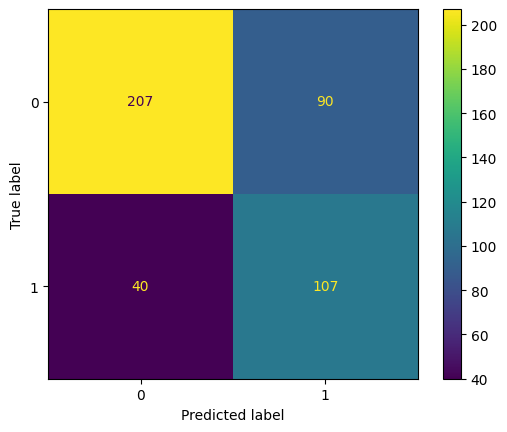

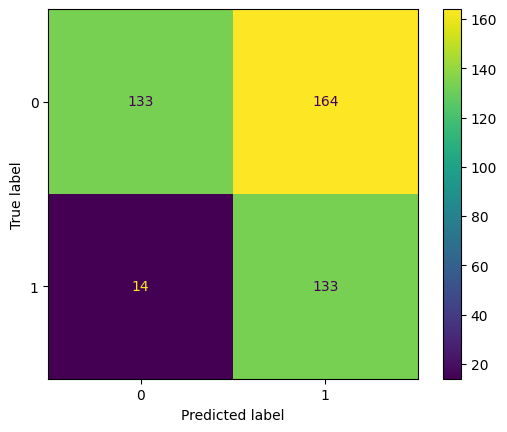

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

thresholds = [0.5, 0.3]
confusion_matrices = {}

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_cleaned_high, y_pred)
    confusion_matrices[threshold] = cm

    print(f"Matriz de Confusão para Limiar = {threshold}:")
    print(cm)
    ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot()

### Testes

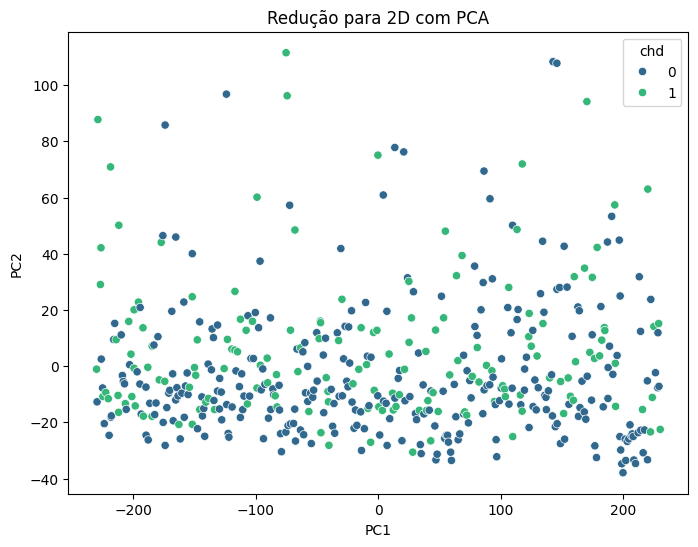

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Aplicando PCA para reduzir para 2 dimensões
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.drop(columns=["chd"]))  # Excluímos a variável target

# Adicionando os componentes ao DataFrame
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["chd"] = df["chd"]

# Visualizando
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="chd", palette="viridis")
plt.title("Redução para 2D com PCA")
plt.show()

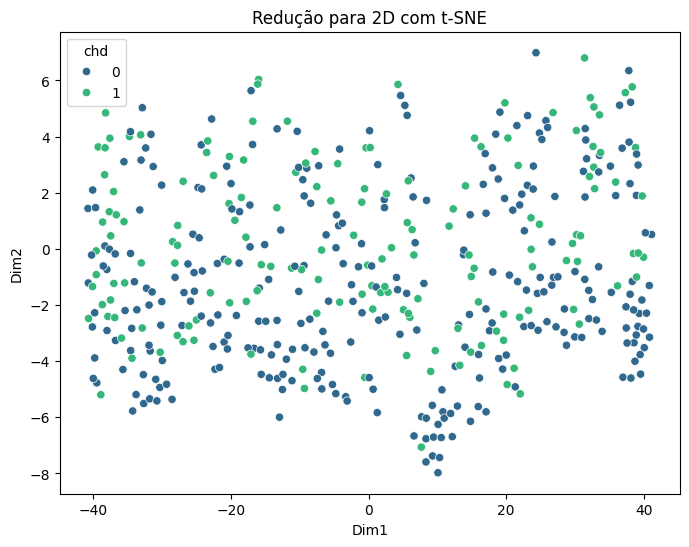

In [ ]:
from sklearn.manifold import TSNE

# Aplicando t-SNE para reduzir para 2 dimensões
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df.drop(columns=["chd"]))

# Adicionando os componentes ao DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
df_tsne["chd"] = df["chd"]

# Visualizando
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x="Dim1", y="Dim2", hue="chd", palette="viridis")
plt.title("Redução para 2D com t-SNE")
plt.show()

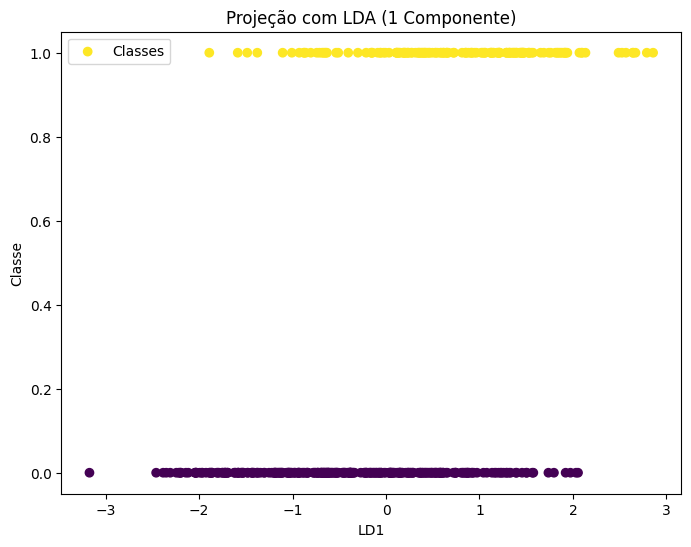

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Ajustando para 1 componente (binário)
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(df.drop(columns=["chd"]), df["chd"])

# Visualizando em 1D
plt.figure(figsize=(8, 6))
plt.scatter(X_lda[:, 0], df["chd"], c=df["chd"], cmap="viridis", label="Classes")
plt.title("Projeção com LDA (1 Componente)")
plt.xlabel("LD1")
plt.ylabel("Classe")
plt.legend()
plt.show()


In [ ]:
df_lda = pd.DataFrame(X_lda, columns=["LD1"])
df_lda["chd"] = df["chd"]

In [ ]:
# Train test
from sklearn.model_selection import train_test_split

X_lda = df_lda["LD1"].values.reshape(-1, 1)
y = df_lda["chd"]

X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((369, 1), (93, 1))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
plot_report_table(classification_report(y_test, y_pred, output_dict=True))

+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |  Metric   |      Class 0       |      Class 1       |     Macro Avg      |    Weighted Avg    |      Accuracy      |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0 | Precision | 0.8103448275862069 | 0.6571428571428571 | 0.7337438423645319 | 0.7543355050585306 |                    |
| 1 |  Recall   | 0.7966101694915254 | 0.6764705882352942 | 0.7365403788634097 | 0.7526881720430108 |                    |
| 2 | F1-Score  | 0.8034188034188035 | 0.6666666666666666 | 0.7350427350427351 | 0.7534233985846889 | 0.7526881720430108 |
| 3 |  Support  |        59.0        |        34.0        |        93.0        |        93.0        |                    |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
from sklearn.svm import SVC

model_svm = SVC(kernel="linear")
model_svm.fit(X_lda, y)  # Ou use X diretamente se não quiser usar LDA

y_pred = model_svm.predict(X_lda)
plot_report_table(classification_report(y, y_pred, output_dict=True))


+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |  Metric   |      Class 0       |      Class 1       |     Macro Avg      |    Weighted Avg    |      Accuracy      |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0 | Precision | 0.7717717717717718 | 0.6511627906976745 | 0.7114672812347231 | 0.7300024276768463 |                    |
| 1 |  Recall   | 0.8509933774834437 |       0.525        | 0.6879966887417219 | 0.7380952380952381 |                    |
| 2 | F1-Score  | 0.8094488188976378 | 0.5813148788927336 | 0.6953818488951857 | 0.7304413937877142 | 0.7380952380952381 |
| 3 |  Support  |       302.0        |       160.0        |       462.0        |       462.0        |                    |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
from sklearn.neural_network import MLPClassifier

model_nn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)
model_nn.fit(X_lda, y)

y_pred = model_nn.predict(X_lda)
plot_report_table(classification_report(y, y_pred, output_dict=True))


+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |  Metric   |      Class 0       |      Class 1       |     Macro Avg      |    Weighted Avg    |      Accuracy      |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0 | Precision | 0.7859424920127795 | 0.6241610738255033 | 0.7050517829191414 | 0.7299142952379654 |                    |
| 1 |  Recall   | 0.8145695364238411 |      0.58125       | 0.6979097682119206 | 0.7337662337662337 |                    |
| 2 | F1-Score  |        0.8         | 0.6019417475728155 | 0.7009708737864078 | 0.7314083974278149 | 0.7337662337662337 |
| 3 |  Support  |       302.0        |       160.0        |       462.0        |       462.0        |                    |
+---+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


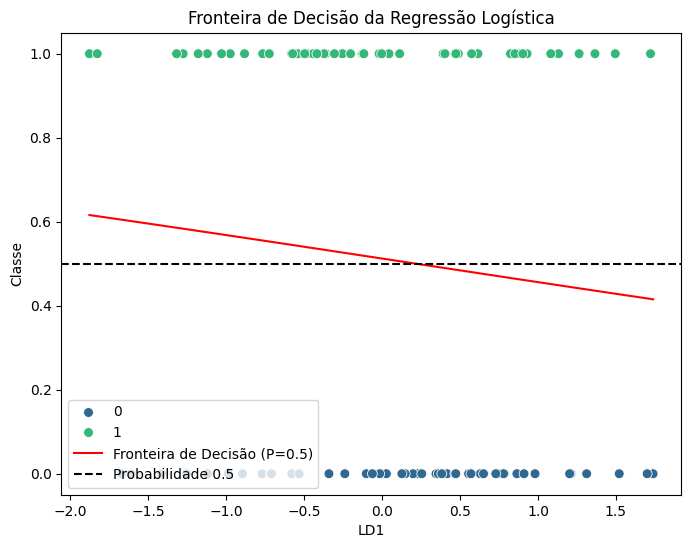

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Gerando dados fictícios para exemplo
df_lda = pd.DataFrame({
    "LD1": np.random.randn(100),
    "chd": np.random.choice([0, 1], size=100)
})

# Separando X (LD1) e y (classe)
X_lda = df_lda[["LD1"]]
y = df_lda["chd"]

# Treinando a regressão logística no LD1
model = LogisticRegression()
model.fit(X_lda, y)

# Gerando a fronteira de decisão
x_vals = np.linspace(X_lda["LD1"].min(), X_lda["LD1"].max(), 100)
y_vals = model.predict_proba(x_vals.reshape(-1, 1))[:, 1]  # Probabilidade para a classe positiva (1)

# Visualizando o gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_lda, x="LD1", y="chd", hue="chd", palette="viridis", s=50)
plt.plot(x_vals, y_vals, color="red", label="Fronteira de Decisão (P=0.5)")
plt.axhline(0.5, color="black", linestyle="--", label="Probabilidade 0.5")
plt.title("Fronteira de Decisão da Regressão Logística")
plt.xlabel("LD1")
plt.ylabel("Classe")
plt.legend()
plt.show()
